In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [3]:

## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso = "Si" 
_path = datapath + "bananas/" + iso
_p_path = datapath +"bananaexplorer/" +iso
simpath = "/home/haue/repositories/Masters/simdata/"

#outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
_p_file = glob.glob(os.path.join(_p_path, "*mlio.root"))

#### Loading in of the data files storing them in a dictionary can be easily expanded to include multiple isotopes
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    iso: _files,
    "p_"+iso: _p_file,
}
data_collection = {
    iso : {},
    "p_"+iso : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)} for isotope in data_files}

for isotope, files in data_files.items():
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Si: 100%|██████████ 11/11 [00:29<00:00,  2.66s/file]
Processing p_Si: 100%|██████████ 11/11 [00:07<00:00,  1.42file/s]


In [4]:
### Could be better implemented to be able to handle n amount of peaks, this could be done like the data is loaded
## or like a class where one can draw different figures like done in the below cells through very few clicks, that would honestly be great
# should be that one instantiates a class by stating the detector id, im not sure i can read in all isotopes at once since the memory usage will be too great. Another way to do it would simply
# be when instantiating a class it loads in the files of the specified isotope, however each call of the class will be slow.
lowlim= 3.92
uplim = 4.12
### Extract the two zones specified in the above figures:
p1_fi =[[_] for _ in range(3)]; p1_bi=[[_] for _ in range(3)]; p1_fedep=[[_] for _ in range(3)]
p1_bedep=[[_] for _ in range(3)]; p1_a=[[_] for _ in range(3)]; p1_angs=[[_] for _ in range(3)]
p1_f=[[_] for _ in range(3)]
p1_angs_fi=[[_] for _ in range(3)];p1_angs_bi=[[_] for _ in range(3)]
p2_fi =[[_] for _ in range(3)]; p2_bi=[[_] for _ in range(3)]; p2_fedep=[[_] for _ in range(3)]
p2_bedep=[[_] for _ in range(3)]; p2_a=[[_] for _ in range(3)]; p2_angs=[[_] for _ in range(3)]
p2_f=[[_] for _ in range(3)]
p2_angs_fi=[[_] for _ in range(3)];p2_angs_bi=[[_] for _ in range(3)]##uhm should be same length but for some reason not..

##Peaks we want to analyze
p1 = 2.99
p2 = 3.877

for i in range(3):
    det = f"id{i}"
    
    for a,b,c,d,v in zip(data_collection[iso][det]["fEdep"], data_collection[iso][det]["bEdep"],
                       data_collection[iso][det]["FI"], data_collection[iso][det]["BI"],data_collection[iso][det]["angle"]):
        if lowlim<=a+b<=uplim:
            p1_fi[i].append(c)
            p1_bi[i].append(d)
            p1_fedep[i].append(a)
            p1_bedep[i].append(b)
            p1_a[i].append(v)
        #elif lowlim2<=a+b<=uplim2:
        #    p2_fi[i].append(c)
        #    p2_bi[i].append(d)
        #    p2_fedep[i].append(a)
        #    p2_bedep[i].append(b)
        #    p2_a[i].append(v)
        else:
            continue
            ###### So the above for loop is one way of iterating over values and putting them into the desired
            ###### arrays, however the below way is most likely a better implementation
            ## should redo
    p1_angs[i] = [v for v,vf,vb in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"]) if lowlim<=vf+vb<=uplim]#and v>0]
    #p2_angs[i] = [v for v,vf,vb in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
    #               data_collection["p_"+iso][det]["bEdep"]) if lowlim2<=vf+vb<=uplim2] #and v>0]
    p1_f[i] = [a for v,a,b in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"]) if lowlim<=a+b<=uplim]# and v>0]
    p1_angs_fi[i] = [F for v,a,b,F,B in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"], data_collection["p_"+iso][det]["FI"],
                   data_collection["p_"+iso][det]["BI"]) if lowlim<=a+b<=uplim]# and v>
    p1_angs_bi[i] = [B for v,a,b,F,B in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
                   data_collection["p_"+iso][det]["bEdep"], data_collection["p_"+iso][det]["FI"],
                   data_collection["p_"+iso][det]["BI"]) if lowlim<=a+b<=uplim]# and v>
    #p2_f[i] = [a for v,a,b in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
    #               data_collection["p_"+iso][det]["bEdep"]) if lowlim2<=a+b<=uplim2]# and v>0] 
    #p2_angs_fi[i] = [F for v,a,b,F,B in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
    #               data_collection["p_"+iso][det]["bEdep"], data_collection["p_"+iso][det]["FI"],
    #               data_collection["p_"+iso][det]["BI"]) if lowlim2<=a+b<=uplim2]# and v>
    #p2_angs_bi[i] = [B for v,a,b,F,B in zip(data_collection["p_"+iso][det]["angle"], data_collection["p_"+iso][det]["fEdep"],
    #               data_collection["p_"+iso][det]["bEdep"], data_collection["p_"+iso][det]["FI"],
    #               data_collection["p_"+iso][det]["BI"]) if lowlim2<=a+b<=uplim2]# and v>


In [5]:
def convert_to_float(value):
    value = value.replace(',', '0.')
    return float(value)

trim_path = simpath+"/TRIM/"
gn = ["4MeV52mu","4MeV53mu","4MeV54mu"]
txt = ".txt"
A = ["", "10", "20", "25", "30"]
Es = []
totals = []
for g in gn:
    files = [trim_path+g+a+txt for a in A]
    energies_eV = [[_] for _ in range(len(files))]
    tot = []
    for f, i in zip(files,range(len(files))): 
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith('T'):
                    parts = line.strip().split()
                    if parts[1]=="4990":
                        break
                    else:
                        energy_eV = convert_to_float(parts[3])
                        energies_eV[i].append(energy_eV)
                        tot.append(energy_eV)
    Es.append([4.091-np.array(i)*1e-6 for i in energies_eV]) 
    totals.append(4.091-np.array(tot)*1e-6)
    ######## WRONG i need only subtract 2-3 keV since 12 keV is for energy also lost in back dead layer
    #I have subtracted 12 keV from 2.99 to account for the average loss due to the dead layers
    # a better implementation would be to construct the detector within the TRIM simulation and run with that

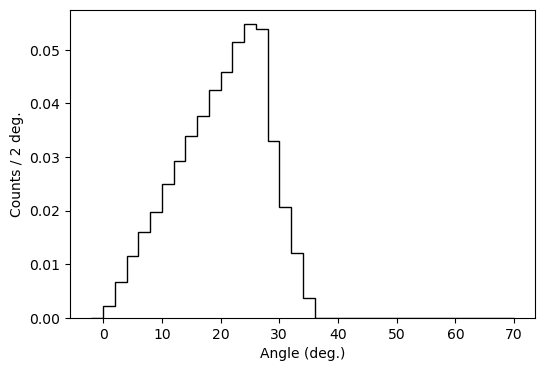

In [6]:
plt.figure(figsize=(6,4))
plt.xlabel("Angle (deg.)")
plt.ylabel("Counts / 2 deg.")
fi, bi, angs, n = np.loadtxt(simpath+"U1Ang.dat", unpack=True)
angs = np.rad2deg(angs)
angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True, label="Simmed ")
plt.show()

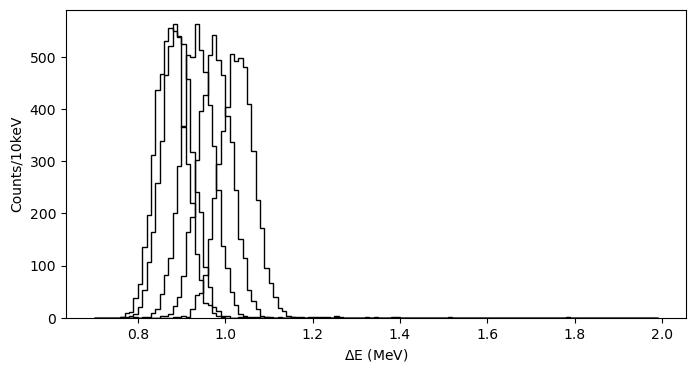

In [7]:

plt.figure(figsize=(8,4))
plt.xlabel(r"$\Delta$E (MeV)")
plt.ylabel("Counts/10keV")
for e in Es[0]:
    plt.hist(e, bins=np.arange(0.7,2, 0.01), histtype='step', color='k')



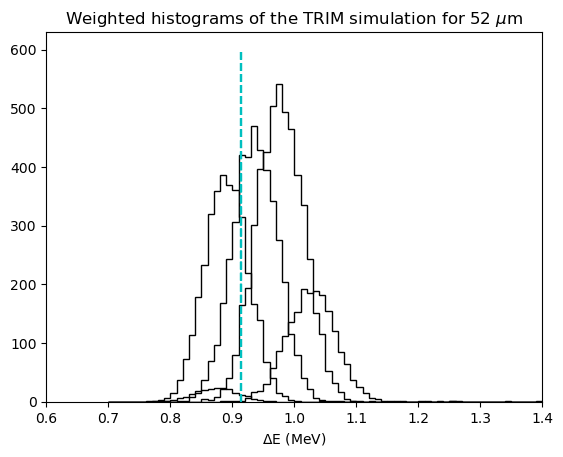

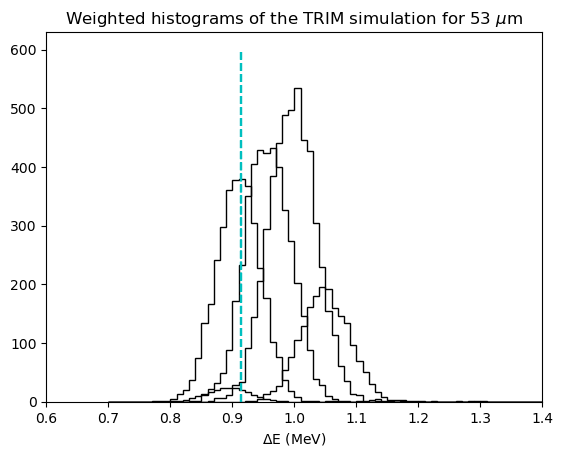

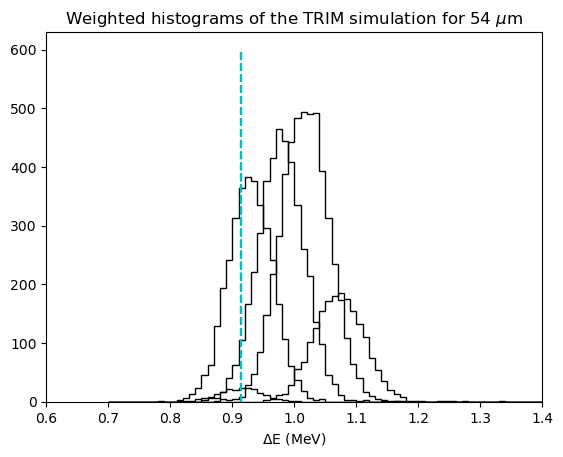

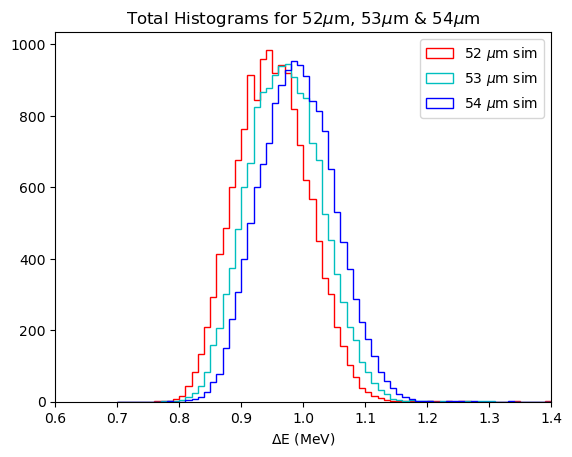

3

In [44]:
arr = [2.26283336e-03, 3.76734626e-02, 4.58407272e-02, 5.47675888e-02, 2.07357240e-02] ## 0,10,20,25,30
tots = []

for i in range(len(Es)):
    plt.figure()
    total_hist = np.zeros(len(np.arange(0.7, 2, 0.01)) - 1)
    for j, r in zip(range(len(Es[i])),arr):
        rel_hist, bin_edges = np.histogram(Es[i][j], bins=np.arange(0.7,2, 0.01))
        maxval = np.max(arr)
        relsize = r/maxval
        rel_hist = rel_hist*relsize
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.hist(bin_edges[:-1], bins=bin_edges, weights=rel_hist, histtype='step', color='k')
        total_hist += rel_hist
        plt.vlines(0.914, 0, 600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
    plt.xlim(0.6,1.4)
    tots.append(total_hist)
    plt.xlabel(r"$\Delta$E (MeV)")
    plt.title(rf"Weighted histograms of the TRIM simulation for {i+52} $\mu$m")

plt.figure()
bin_edges = np.arange(0.7, 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0], histtype='step', color='r', label=r"52 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1], histtype='step', color='c', label=r"53 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[2], histtype='step', color='b', label=r"54 $\mu$m sim")
plt.xlim(0.6,1.4)
plt.title(r"Total Histograms for 52$\mu$m, 53$\mu$m & 54$\mu$m")
plt.xlabel(r"$\Delta$E (MeV)")
plt.legend()
plt.show()
len(tots)

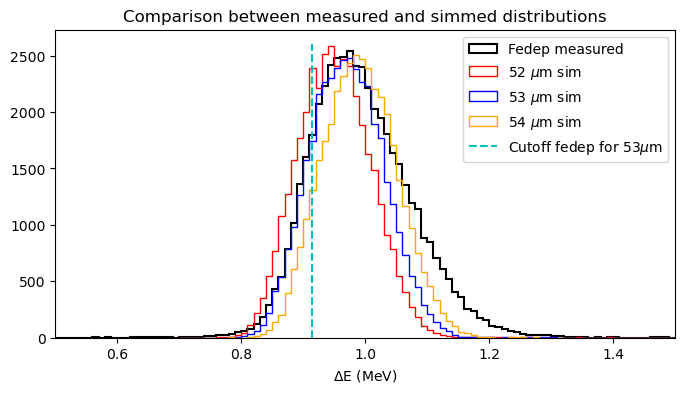

In [39]:
plt.figure(figsize=(8,4))
plt.xlabel(r"$\Delta$E (MeV)")
plt.title("Comparison between measured and simmed distributions")
#plt.ylabel("Counts/10keV")
#plt.yscale('log')
calc_fedeps = [a for a,v in zip(p1_f[0],p1_angs[0]) if v>0] 
plt.hist(p1_fedep[0], bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured", lw=1.5)
bin_edges = np.arange(0.7, 2, 0.01)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
scale = 2.62
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[0]*scale, histtype='step', color='r', label=r"52 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[1]*scale, histtype='step', color='b', label=r"53 $\mu$m sim")
plt.hist(bin_edges[:-1], bins=bin_edges, weights=tots[2]*scale, histtype='step', color='orange', label=r"54 $\mu$m sim")

plt.xlim(0.5, 1.5)
#plt.ylim(1, 1e4)
plt.vlines(0.914, 0, 2600, ls='--', color='c', label=r"Cutoff fedep for 53$\mu$m")
plt.legend()

plt.show()

